Import bibliotek

In [ ]:
!pip install pandas
!pip install torch
!pip install torchaudio
!pip install lightning
!pip install kagglehub
!pip install scikit-learn
!pip install ipython
!pip install soundfile
!pip install wandb
!pip install onnx onnxscript onnxruntime

!pip install "resampy>=0.4.0"
!pip install numpy scipy tqdm requests julius
!pip install torchopenl3 --no-deps
!pip install torchcodec

In [21]:
import os
import shutil
import pandas as pd
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning.loggers import WandbLogger
import kagglehub
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
import torchmetrics
import torch.optim as optim
import torchopenl3
import numpy as np
import wandb
from IPython.display import Audio
from tqdm.auto import tqdm
import gdown
import glob

wandb.login()

True

Download dataset

In [22]:
target_dir = "dataset"

if os.path.exists(target_dir) and len(os.listdir(target_dir)) > 0:
    print(f"Dataset już istnieje w folderze '{target_dir}'. Pomijam pobieranie.")
else:
    print("Dataset nie znaleziony. Rozpoczynam pobieranie...")
    path = kagglehub.dataset_download("junewookim/mad-dataset-military-audio-dataset")
    print("Cache KaggleHub:", path)

    os.makedirs(target_dir, exist_ok=True)
    shutil.copytree(path, target_dir, dirs_exist_ok=True)
    print("Pobrano i zapisano do:", target_dir)

noise_folder = "dataset/noises"
os.makedirs(noise_folder, exist_ok=True)

Dataset już istnieje w folderze 'dataset'. Pomijam pobieranie.


### Pobieranie szumów z dysku google
Ten fragment ma za zadanie pobrać szumy na colaba z dysku google jeżeli jakiegoś dzwięku szumów nie ma w docelowym folderze. Gdy ktoś chce dodać inne szumy to należy dodać je do folderu pod tym adresem URL: https://drive.google.com/drive/folders/14Q_0KNDXACkFQ2oTF1T-gnjIaNbNuaKL?usp=sharing

In [23]:
url = "https://drive.google.com/drive/folders/14Q_0KNDXACkFQ2oTF1T-gnjIaNbNuaKL?usp=sharing"
output_folder = "dataset/noises"

os.makedirs(output_folder, exist_ok=True)

existing_wavs = list(Path(output_folder).glob("*.wav"))

if len(existing_wavs) > 0:
    print(f"Folder {output_folder} zawiera już {len(existing_wavs)} plików. Pomijam pobieranie.")
else:
    print("Folder pusty. Rozpoczynam pobieranie szumów z Google Drive...")
    try:
        gdown.download_folder(url, output=output_folder, quiet=False, use_cookies=False)
        print("Pobieranie zakończone sukcesem.")
    except Exception as e:
        print(f"Wystąpił błąd podczas pobierania: {e}")
        print("Upewnij się, że link na Google Drive jest ustawiony jako 'Każdy mający link' (Anyone with the link).")

noise_files_list = list(Path(output_folder).glob("*.wav"))
print(f"Gotowe. Dostępnych plików szumu do treningu: {len(noise_files_list)}")

Folder dataset/noises zawiera już 5 plików. Pomijam pobieranie.
Gotowe. Dostępnych plików szumu do treningu: 5


### Funkcja dodająca szum
Funkcja pomocnicza do augmentacji danych poprzez dodawanie szumu do nagrań.

In [24]:
def rms_normalize(wav, eps=1e-8):
    rms = torch.sqrt(torch.mean(wav ** 2))
    return wav / (rms + eps)


def aggressive_augment(waveform, noise_files,do_augment=True, sr=48000):
    """
    Zaawansowana augmentacja: losowy Gain, losowy SNR, losowy fragment szumu.
    """
    # 1. Losowe wzmocnienie (Gain) - symulacja różnych odległości od mikrofonu
    gain = random.uniform(0.5, 1.5)
    aug_wav = waveform * gain

    # 2. Dodawanie szumu
    if noise_files and len(noise_files) > 0:
        noise_path = random.choice(noise_files)
        # Ładowanie szumu
        noise_wav, noise_sr = torchaudio.load(noise_path)

        # Resample szumu jeśli trzeba
        if noise_sr != sr:
            resampler = torchaudio.transforms.Resample(noise_sr, sr)
            noise_wav = resampler(noise_wav)

        # Upewnij się, że szum jest mono
        if noise_wav.shape[0] > 1:
            noise_wav = noise_wav.mean(dim=0, keepdim=True)

        L_signal = aug_wav.shape[1]
        L_noise = noise_wav.shape[1]

        # Dopasowanie długości (Twoje wymaganie: losowe fragmenty)
        if L_noise < L_signal:
            repeats = int(L_signal / L_noise) + 1
            noise_wav = noise_wav.repeat(1, repeats)
            noise_wav = noise_wav[:, :L_signal]
        elif L_noise > L_signal:
            start_max = L_noise - L_signal
            start = random.randint(0, start_max)
            noise_wav = noise_wav[:, start : start + L_signal]

        # Mieszanie z losowym SNR (Signal-to-Noise Ratio)
        # SNR 5 (głośny szum) do 25 (cichy szum)
        snr_db = random.uniform(10.0, 30.0)

        signal_power = aug_wav.norm(p=2)
        noise_power = noise_wav.norm(p=2)

        if noise_power > 0:
            snr = 10 ** (snr_db / 20)
            scale = signal_power / (noise_power * snr + 1e-9)
            if do_augment:
                aug_wav = aug_wav + (noise_wav * scale)

    # 3. Clip (symulacja przesteru)
    if random.random() > 0.3:
        aug_wav = torch.clamp(aug_wav, -0.95, 0.95)

    aug_wav = rms_normalize(aug_wav)
    return aug_wav

### Klasa ekstraktora cech OpenL3
Klasa wrapper dla modelu OpenL3 służąca do ekstrakcji embeddingów z plików audio.

In [25]:
class OpenL3FeatureExtractor:
    """
    Ekstraktor cech audio za pomocą modelu torchopenl3 (PyTorch)
    """
    def __init__(self, input_repr="mel128", content_type="music", embedding_size=512):
        """
        input_repr: "mel128" lub "mel256"
        content_type: "music" lub "env" (w torchopenl3 'environmental' to 'env')
        embedding_size: 512 lub 6144
        """
        if content_type == "environmental":
            content_type = "env"

        print(f"Ładowanie modelu TorchOpenL3: {input_repr}, {content_type}, embedding_size={embedding_size}")

        self.model = torchopenl3.models.load_audio_embedding_model(
            input_repr=input_repr,
            content_type=content_type,
            embedding_size=embedding_size
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

        self.input_repr = input_repr
        self.content_type = content_type
        self.embedding_size = embedding_size
        self.sample_rate = 8000

    def extract_features(self, waveform):
        """
        waveform: [channels, samples] lub [batch, channels, samples]
        """

        if waveform.dim() == 3:   # [batch, channels, samples]
            waveform = waveform.mean(dim=1)  # [batch, samples]
        elif waveform.dim() == 2: # [channels, samples]
            waveform = waveform.unsqueeze(0) # [1, samples]

        waveform = waveform.to(self.device)

        with torch.no_grad():
            embeddings, _ = torchopenl3.get_audio_embedding(
                waveform,
                sr=48000,
                model=self.model,
                hop_size=0.1,
                verbose=False
            )

        aggregated = embeddings.mean(dim=1)  # mean pooling po czasie
        return aggregated.cpu()



print("Inicjalizacja TorchOpenL3 Feature Extractor...")
feature_extractor = OpenL3FeatureExtractor(
    input_repr="mel128",
    content_type="music",
    embedding_size=512
)
print(f"OpenL3 ekstraktor załadowany na urządzeniu: {feature_extractor.device}")

Inicjalizacja TorchOpenL3 Feature Extractor...
Ładowanie modelu TorchOpenL3: mel128, music, embedding_size=512
OpenL3 ekstraktor załadowany na urządzeniu: cuda


In [26]:
def generate_augmented_dataset(
    df,
    root_dir,
    output_base_dir,
    feature_extractor,
    noise_files,
    do_agument=True,
    augmentations_per_file=5
):
    # Tworzenie struktur folderów
    audio_out_dir = os.path.join(output_base_dir, "audio")
    features_out_dir = os.path.join(output_base_dir, "features")

    os.makedirs(audio_out_dir, exist_ok=True)
    os.makedirs(features_out_dir, exist_ok=True)

    new_data = []

    print(f"Generowanie datasetu. Wersji na plik: {augmentations_per_file}")
    print(f"Folder docelowy: {output_base_dir}")

    # Upewnij się, że model jest na GPU
    feature_extractor.model.to(feature_extractor.device)

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        original_path = str(row['path'])
        label = row['label']
        full_path = os.path.join(root_dir, original_path)

        # Nazwa bazowa pliku (bez .wav)
        filename_base = os.path.basename(original_path).replace(".wav", "")

        try:
            # 1. Wczytaj oryginał
            wav, sr = torchaudio.load(full_path)

            # Resample do 48k (OpenL3 wymaga 48k)
            if sr != 48000:
                wav = torchaudio.transforms.Resample(sr, 48000)(wav)

            # Pad/Trim do stałej długości (ok 3.3 sekundy)
            target_len = 160000
            if wav.shape[1] > target_len:
                wav = wav[:, :target_len]
            else:
                wav = F.pad(wav, (0, target_len - wav.shape[1]))

            # --- Pętla augmentacji ---
            for i in range(augmentations_per_file):
                new_filename = f"{filename_base}_aug_{i}"
                wav_save_path = os.path.join(audio_out_dir, f"{new_filename}.wav")
                feat_save_path = os.path.join(features_out_dir, f"{new_filename}.pt")

                # Jeśli pliki już istnieją, dodaj do listy i pomiń obliczenia (cache)
                if os.path.exists(wav_save_path) and os.path.exists(feat_save_path):
                    new_data.append({
                        "path": wav_save_path,
                        "feature_path": feat_save_path,
                        "label": label
                    })
                    continue

                # A. Augmentacja
                current_wav = wav.clone()
                # Używamy nowej funkcji augmentacji

                noisy_wav = aggressive_augment(current_wav, noise_files,do_agument, sr=48000)

                # B. Ekstrakcja cech
                with torch.no_grad():
                    # extract_features zwraca [512] (dzięki .mean() wewnątrz Twojej klasy)
                    features = feature_extractor.extract_features(noisy_wav)
                    if features.dim() > 1:
                        features = features.squeeze(0) # Upewnij się że mamy [512]

                # C. Zapis
                torchaudio.save(wav_save_path, noisy_wav, 48000)
                torch.save(features.cpu(), feat_save_path)

                new_data.append({
                    "path": wav_save_path,
                    "feature_path": feat_save_path,
                    "label": label
                })

        except Exception as e:
            print(f"Błąd przy pliku {original_path}: {e}")

    # Zwracamy nowy DataFrame z wygenerowanymi ścieżkami
    return pd.DataFrame(new_data)

# Setup
features_cache_path = "dataset/processed_augmented" # Nowy folder na przetworzone dane
noise_folder_path = "dataset/MAD_dataset/noise" # lub gdzie masz szumy
noise_files_list = list(Path(noise_folder_path).glob("*.wav"))

df_full = pd.read_csv("dataset/MAD_dataset/training.csv")

# Wywołanie generatora
df_augmented = generate_augmented_dataset(
    df=df_full, # Twój oryginalny DataFrame
    root_dir="dataset/MAD_dataset",
    output_base_dir=features_cache_path,
    feature_extractor=feature_extractor,
    noise_files=noise_files_list,
    do_agument=True,
    augmentations_per_file=5  # 5 wersji na każdy plik -> 5x więcej danych!
)

print(f"Nowy rozmiar datasetu: {len(df_augmented)}")

Generowanie datasetu. Wersji na plik: 5
Folder docelowy: dataset/processed_augmented


  0%|          | 0/6429 [00:00<?, ?it/s]

Nowy rozmiar datasetu: 32145


### Klasa Dataset na surowym audio
Podstawowa klasa Dataset zwracająca pary nagrań (surowe waveformy) oraz informację czy należą do tej samej klasy.

In [27]:


class SiameseAudioDataset(Dataset):
    def __init__(self, df, pairs_per_sample=1):
        self.df = df.reset_index(drop=True)
        self.pairs = []

        label_groups = self.df.groupby("label").indices

        for idx, row in self.df.iterrows():
            label = row["label"]

            # Positive
            pos_indices = label_groups[label]
            pos_idx = idx
            while pos_idx == idx:
                pos_idx = random.choice(pos_indices)

            self.pairs.append((idx, pos_idx, 1))

            # Negative
            neg_label = random.choice([l for l in label_groups.keys() if l != label])
            neg_idx = random.choice(label_groups[neg_label])
            self.pairs.append((idx, neg_idx, 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        idx_a, idx_b, same_label = self.pairs[idx]

        row_a = self.df.iloc[idx_a]
        row_b = self.df.iloc[idx_b]

        feat_a = torch.load(row_a["feature_path"])
        feat_b = torch.load(row_b["feature_path"])


        dummy = torch.empty(1)
        return dummy, row_a["label"], dummy, row_b["label"], same_label, 48000, feat_a, feat_b


In [28]:
def siamese_collate(batch):
    a = torch.stack([item[0] for item in batch])
    label_a = torch.tensor([item[1] for item in batch], dtype=torch.long)
    b = torch.stack([item[2] for item in batch])
    label_b = torch.tensor([item[3] for item in batch], dtype=torch.long)
    same_label = torch.tensor([item[4] for item in batch], dtype=torch.long)
    sample_rate = batch[0][5]

    features_a = torch.stack([item[6] for item in batch]) if batch[0][6] is not None else None
    features_b = torch.stack([item[7] for item in batch]) if batch[0][7] is not None else None

    return a, label_a, b, label_b, same_label, sample_rate, features_a, features_b

### DataModule dla surowego audio
Klasa LightningDataModule zarządzająca datasetami treningowymi i walidacyjnymi dla surowego audio.

In [29]:

class SiameseAudioDataModule(LightningDataModule):
    def __init__(self, df, batch_size=32, num_workers=4): # usunięto features_dir
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        train_df, val_df = train_test_split(self.df, test_size=0.2, random_state=42, stratify=self.df['label'])
        self.train_ds = SiameseAudioDataset(train_df) # Tylko DF
        self.val_ds = SiameseAudioDataset(val_df)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, collate_fn=siamese_collate)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, collate_fn=siamese_collate)

In [30]:
dm_test = SiameseAudioDataModule(
    df=df_augmented,      # <--- ZMIANA: używamy nowego DataFrame z wygenerowanymi cechami
    batch_size=32,
    num_workers=4
    # features_dir - USUNIĘTO (klasa już tego nie przyjmuje)
)
dm_test.setup()
batch = next(iter(dm_test.train_dataloader()))
print("Features shape:", batch[6].shape) # Powinno być [8, 512]
print("Działa!")

Features shape: torch.Size([32, 512])
Działa!


### Model Syjamski (LightningModule)
Definicja modelu sieci neuronowej (klasyfikatora), który przyjmuje różnicę cech dwóch nagrań i decyduje czy są to te same klasy.

In [31]:
class ResidualBlock(nn.Module):
    """
    Blok rezydualny dla sieci MLP.
    Pozwala budować głębokie sieci bez problemu zanikającego gradientu.
    x -> [Linear->BN->ReLU->Dropout->Linear->BN] + x -> ReLU
    """
    def __init__(self, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.block(x)
        out += identity  # Skip connection (kluczowe dla głębokich sieci)
        return self.relu(out)

class SiameseComparator(pl.LightningModule):
    def __init__(self, input_dim=1024, hidden_dim=1024, learning_rate=5e-4):
        super().__init__()
        self.save_hyperparameters()

        # Wejście: [u, v, |u-v|, u*v] -> 4 * 512 = 2048
        concat_dim = input_dim * 4

        # 1. Projekcja wejścia do przestrzeni ukrytej (szerokiej)
        self.input_projection = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # 2. Głęboka część sieci (Stack bloków rezydualnych)
        # To daje nam ekwiwalent ~8-10 gęstych warstw, ale stabilnych w treningu
        self.res_blocks = nn.Sequential(
            ResidualBlock(hidden_dim, dropout_rate=0.2),
            ResidualBlock(hidden_dim, dropout_rate=0.2),
            ResidualBlock(hidden_dim, dropout_rate=0.2),
            ResidualBlock(hidden_dim, dropout_rate=0.2)
        )

        # 3. Głowa klasyfikacyjna (Head) - zawężanie do wyniku
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2), # 1024 -> 512
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim // 2, 512),        
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),


            nn.Linear(256, 1)                       # Wynik (logit)
        )

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.accuracy = torchmetrics.Accuracy(task="binary")
        self.f1_score = torchmetrics.F1Score(task="binary")

    def forward(self, feat_a, feat_b):
        # Normalizacja L2 nadal jest kluczowa!
        u = F.normalize(feat_a, p=2, dim=1)
        v = F.normalize(feat_b, p=2, dim=1)

        # Bogate cechy
        features = torch.cat([
            u,
            v,
            torch.abs(u - v),
            u * v
        ], dim=1)

        # Przepływ przez sieć
        x = self.input_projection(features)
        x = self.res_blocks(x)
        return self.head(x)

    def training_step(self, batch, batch_idx):
        _, _, _, _, same_label, _, features_a, features_b = batch

        logits = self(features_a, features_b)
        logits = logits.squeeze(1)

        loss = self.loss_fn(logits, same_label.float())

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.accuracy(preds, same_label), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, _, _, same_label, _, features_a, features_b = batch

        logits = self(features_a, features_b)
        logits = logits.squeeze(1)
        loss = self.loss_fn(logits, same_label.float())

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy(preds, same_label), prog_bar=True)
        self.log("val_f1", self.f1_score(preds, same_label), prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Dla większej sieci OneCycleLR często działa lepiej i szybciej zbiega
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-3)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}
        }

### Trening modelu

In [13]:
dm = SiameseAudioDataModule(
    df=df_augmented,
    batch_size=32,
    num_workers=4
)

model = SiameseComparator(input_dim=512, hidden_dim=256, learning_rate=0.001)

wandb_logger = WandbLogger(
    project="siamese-audio-classifier",
    entity="deep-neural-network-course",
    name="Iwo_Rymer_test_changed_siamese_dataset",
    log_model="all"
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1,
    logger=wandb_logger,
    log_every_n_steps=5
)

print("Rozpoczynam trening z logowaniem do W&B...")
trainer.fit(model, datamodule=dm)

print("Trening zakończony!")
wandb.finish()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.


Rozpoczynam trening z logowaniem do W&B...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params | Mode  | FLOPs
-----------------------------------------------------------------------
0 | input_projection | Sequential        | 525 K  | train | 0    
1 | res_blocks       | Sequential        | 530 K  | train | 0    
2 | head             | Sequential        | 232 K  | train | 0    
3 | loss_fn          | BCEWithLogitsLoss | 0      | train | 0    
4 | accuracy         | BinaryAccuracy    | 0      | train | 0    
5 | f1_score         | BinaryF1Score     | 0      | train | 0    
-----------------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.151     Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/iwo/GSN/siamese-audio-classifier/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/iwo/GSN/siamese-audio-classifier/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/iwo/GSN/siamese-audio-classifier/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7d65d99cf700>> (for post_run_cell), with arguments args (<ExecutionResult object at 7d677006a9e0, execution_count=13 error_before_exec=None error_in_exec=1 info=<ExecutionInfo object at 7d677006b130, raw_cell="dm = SiameseAudioDataModule(
    df=df_augmented,
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/iwo/GSN/siamese-audio-classifier/dataloader.ipynb#X30sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

***Obliczanie cosilne baseline***
(sprawdzenie czy embeddingi się różnią: jak prawie wszystko pod 1 to Open L3 nie widzi różnic między klasami)

  0%|          | 0/5000 [00:00<?, ?it/s]

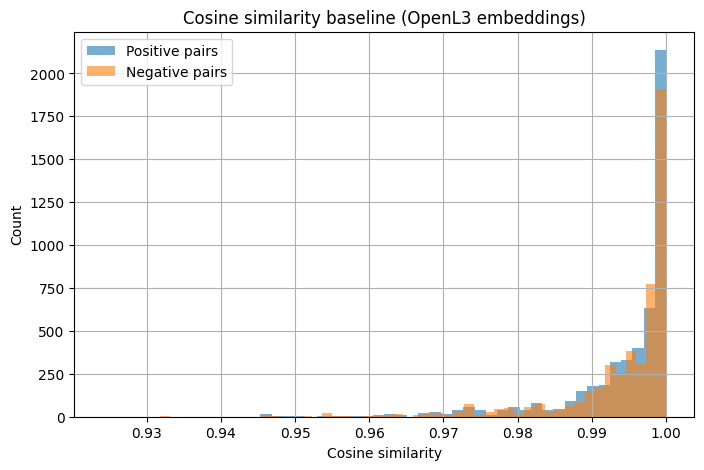

In [32]:
def compute_cosine_baseline(
    df,
    num_pairs=5000,
    seed=42
):
    random.seed(seed)
    torch.manual_seed(seed)

    label_groups = df.groupby("label").indices
    labels = list(label_groups.keys())

    positive_sims = []
    negative_sims = []

    for _ in tqdm(range(num_pairs)):
        idx_a = random.randrange(len(df))
        row_a = df.iloc[idx_a]
        label_a = row_a["label"]

        feat_a = torch.load(row_a["feature_path"]).float().squeeze(0)
        if torch.isnan(feat_a).any():
            continue
        feat_a = feat_a / (feat_a.norm(p=2) + 1e-8)

        # POSITIVE
        pos_idx = idx_a
        while pos_idx == idx_a:
            pos_idx = random.choice(label_groups[label_a])

        feat_p = torch.load(df.iloc[pos_idx]["feature_path"]).float().squeeze(0)
        if torch.isnan(feat_p).any():
            continue
        feat_p = feat_p / (feat_p.norm(p=2) + 1e-8)

        positive_sims.append(torch.dot(feat_a, feat_p).item())

        # NEGATIVE
        neg_label = random.choice([l for l in labels if l != label_a])
        neg_idx = random.choice(label_groups[neg_label])

        feat_n = torch.load(df.iloc[neg_idx]["feature_path"]).float().squeeze(0)
        if torch.isnan(feat_n).any():
            continue
        feat_n = feat_n / (feat_n.norm(p=2) + 1e-8)

        negative_sims.append(torch.dot(feat_a, feat_n).item())

    return np.array(positive_sims), np.array(negative_sims)


pos_sims, neg_sims = compute_cosine_baseline(df_augmented, num_pairs=5000)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.hist(pos_sims, bins=50, alpha=0.6, label="Positive pairs")
plt.hist(neg_sims, bins=50, alpha=0.6, label="Negative pairs")

plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.title("Cosine similarity baseline (OpenL3 embeddings)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
print("=== COSINE BASELINE STATS ===")
print(f"Positive: mean={pos_sims.mean():.3f}, std={pos_sims.std():.3f}")
print(f"Negative: mean={neg_sims.mean():.3f}, std={neg_sims.std():.3f}")

# Prosty threshold test
threshold = 0.5
pos_acc = (pos_sims > threshold).mean()
neg_acc = (neg_sims < threshold).mean()
print(f"Accuracy @ threshold={threshold}: {(pos_acc + neg_acc) / 2:.3f}")


=== COSINE BASELINE STATS ===
Positive: mean=0.994, std=0.008
Negative: mean=0.994, std=0.009
Accuracy @ threshold=0.5: 0.500


In [34]:
print(np.isnan(pos_sims).mean(), np.isnan(neg_sims).mean())
print(pos_sims.mean(), neg_sims.mean())


0.0 0.0
0.9942584441781044 0.9942747221946716


In [35]:
wav, _ = torchaudio.load(df_augmented.iloc[0]["path"])
print(wav.abs().mean(), wav.abs().max())


tensor(0.2073) tensor(1.)


In [20]:
row = df_augmented.iloc[0]
feat = torch.load(row["feature_path"])

print("type:", type(feat))
print("shape:", feat.shape)
print("dtype:", feat.dtype)

print("min:", feat.min().item())
print("max:", feat.max().item())
print("mean:", feat.mean().item())
print("std:", feat.std().item())

print("any NaN:", torch.isnan(feat).any().item())
print("any Inf:", torch.isinf(feat).any().item())
print("norm:", feat.norm().item())


type: <class 'torch.Tensor'>
shape: torch.Size([1024])
dtype: torch.float32
min: nan
max: nan
mean: nan
std: nan
any NaN: True
any Inf: False
norm: nan


In [14]:
df_augmented.head()

,path,feature_path,label
0,dataset/processed_augmented/audio/0_aug_0.wav,dataset/processed_augmented/features/0_aug_0.pt,3
1,dataset/processed_augmented/audio/0_aug_1.wav,dataset/processed_augmented/features/0_aug_1.pt,3
2,dataset/processed_augmented/audio/0_aug_2.wav,dataset/processed_augmented/features/0_aug_2.pt,3
3,dataset/processed_augmented/audio/0_aug_3.wav,dataset/processed_augmented/features/0_aug_3.pt,3
4,dataset/processed_augmented/audio/0_aug_4.wav,dataset/processed_augmented/features/0_aug_4.pt,3


**Zapisywanie do ONNX**

In [ ]:
search_pattern = "siamese-audio-classifier/**/*.ckpt"
list_of_files = glob.glob(search_pattern, recursive=True)

if not list_of_files:
    print("Nie znaleziono checkpointu .ckpt do eksportu!")
else:
    latest_checkpoint = max(list_of_files, key=os.path.getctime)
    print(f"Eksportuję model z pliku: {latest_checkpoint}")

    device = torch.device("cpu") # Do eksportu ONNX bezpieczniej użyć CPU
    model_export = SiameseComparator.load_from_checkpoint(latest_checkpoint)
    model_export.to(device)
    model_export.eval()

    dummy_input_a = torch.randn(1, 512, device=device)
    dummy_input_b = torch.randn(1, 512, device=device)

    onnx_path = "siamese_audio_comparator.onnx"

    try:
        torch.onnx.export(
            model_export,
            (dummy_input_a, dummy_input_b),
            onnx_path,
            export_params=True,
            opset_version=12,
            do_constant_folding=True,
            input_names=['feature_vector_a', 'feature_vector_b'],
            output_names=['similarity_score'],
            dynamic_axes={
                'feature_vector_a': {0: 'batch_size'},
                'feature_vector_b': {0: 'batch_size'},
                'similarity_score': {0: 'batch_size'}
            }
        )
        print(f"Sukces! Model zapisany jako: {onnx_path}")

    except Exception as e:
        print(f"Błąd podczas eksportu do ONNX: {e}")